 <font color='blue'> **30. Unsaturated Zone Flow (UZF) Package** </font> Drainage Discharge Scaling 
 <font color='red'> **SFR** </font> 

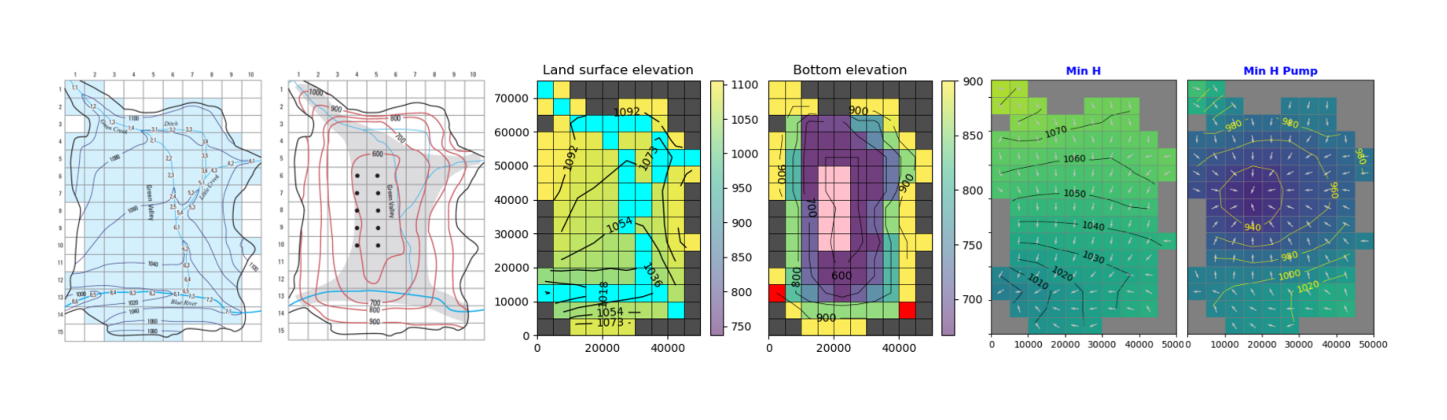

In [1]:
from pathlib import Path ; import os ; import flopy ;  import matplotlib.pyplot as plt ; import numpy as np ; from flopy.plot.styles import styles
from modflow_devtools.latex import build_table, exp_format, float_format, int_format  ; import pickle  ; import pandas as pd
from modflow_devtools.misc import get_env ; write = get_env("WRITE", True) ; run = get_env("RUN", True)
sim_name = "ex-gwf-drn-p01" ; workspace = Path("./28_UZF")      ; workspace.mkdir(exist_ok=True)    ; exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe'  
fig = plt.figure(figsize=(16, 5), dpi=500)        
ax = fig.add_subplot(141) ;image=plt.imread('E:/15_REPOS/00_BETAMI/00_MF6/_aux/30_11_SRF3.png') ;ax.imshow(image) ;ax.axis('off') ; plt.show() 

In [2]:
sim_data  = Path("./_aux/11_sfr")
with open(sim_data/ "a_sfr_pakdata" ,'rb') as handle: sfr_pakdata = pickle.load(handle)   ;a1=pd.DataFrame(sfr_pakdata) ;a1.to_csv(workspace/"01_sfr1.csv")
with open(sim_data/ "b_sfr_conn   " ,'rb') as handle: sfr_conn    = pickle.load(handle)   ;a1=pd.DataFrame(sfr_conn)    ;a1.to_csv(workspace/"02_sfr2.csv")

In [3]:
path1  = 'E:\\15_REPOS\\00_BETAMI\\bin\\data_modflow6-examples\\ex-gwf-sfr-p01'; path2 = 'E:\\15_REPOS\\00_BETAMI\\bin\\data_modflow6-examples\\ex-gwf-drn-p01' 
fpath1 = os.path.join(path1,"idomain.txt")     ; idomain = np.loadtxt(fpath1, dtype=int)
fpath2 = os.path.join(path1,"bottom.txt" )     ; botm    = np.loadtxt(fpath2, dtype=float)
fpath3 = os.path.join(path1,"top.txt"    )     ; top     = np.loadtxt(fpath3, dtype=float)
fpath4 = os.path.join(path2,"infilt_mult.txt") ; infilt_mult = np.loadtxt(fpath4, dtype=float)
fpath5 = os.path.join(path2,"extwc_mult.txt" ) ; extwc_mult  = np.loadtxt(fpath5, dtype=float)
fpath6 = os.path.join(path2,"routing_map.txt") ; routing_map = np.loadtxt(fpath6, dtype=int)

In [4]:
parameters   = {"ex-gwf-drn-p01a": {"uzf_gwseep": None,},"ex-gwf-drn-p01b": {"uzf_gwseep": True,},}
length_units = "feet" ;time_units = "seconds"           ;nlay = 1 ;nrow = 15     ; ncol = 10 ; delr = 5000 ;delc = 5000 ;strt = 1050 ;k11_stream = 0.002 
k11_basin = 0.0004 ;ss = 0.000001 ;sy_stream = 0.2 ;sy_basin = 0.1               ; uzf_kv = 0.000001 ;thts = 0.3 ;thti = 0.1 ;thtr = 0.1 ;eps = 3.5 
evap_rate = 0.00000005 ;extwc = 0.10005 ;ext_depth = 15 ;surf_dep = 1            ; nouter = 100 ; ninner = 50 ; hclose = 1e-6 ; rclose = 1e-6
nper = 12 ;tdis_ds = [(2628000.0, 1, 1.0)]
for n in range(nper - 1): tdis_ds.append((2628000.0, 15, 1.1))
extents      = (0.0, delr * ncol, 0.0, delc * nrow)     ; shape2d = (nrow, ncol) ; shape3d = (nlay, nrow, ncol)

routing_map -= 1
k11 = np.zeros(shape2d, dtype=float)  ; k11[idomain == 1] = k11_stream ; k11[idomain == 2] = k11_basin
sy = np.zeros(shape2d, dtype=float)   ; sy [idomain == 1] = sy_stream  ; sy [idomain == 2] = sy_basin
infiltration=(1.0e-9,8.0e-9,1.0e-8,2.0e-8,5.0e-9,1.0e-8,3.0e-9,5.0e-9,3.0e-9,2.0e-9,1.0e-9,1.0e-9,)
well_rates=(-2.0,-2.0,-1.0,-1.0,-3.0,0.0,-2.0,0.0,-1.0,0.0,-3.0,0.0,) ; ghb_spd = [[0, 12, 0, 988.0, 0.038],[0, 13, 8, 1045.0, 0.038],] ; wel_spd = {}
for n in range(nper): 
    q = well_rates[n]
    if q == 0.0:
        wel_spd[n] = [[]]
    else: 
        wel_spd[n]=[[0,5,3,q],[0,5,4,q],[0,6,3,q],[0,6,4,q],[0,7,3,q],[0,7,4,q],[0,8,3,q],[0,8,4,q],[0,9,3,q],[0,9,4,q],]
drn_spd = []
for i in range(nrow):
    for j in range(ncol):
        if idomain[i, j] == 0:
            continue
        drncell = [0, i, j, top[i, j] - 0.5 * surf_dep, 25.0, 1.0, "surfrate"]    ; drn_spd.append(drncell)

uzf_pakdata = []  ; iuzf = 0
for i in range(nrow):
    for j in range(ncol):
        if idomain[i, j] == 0:
            continue
        uzfcell = [iuzf ,0 ,i ,j ,1 ,-1 ,surf_dep ,uzf_kv ,thtr*extwc_mult[i ,j] ,thts ,thti*extwc_mult[i ,j] ,eps ,"surfrate" ,]
        uzf_pakdata.append(uzfcell) ; iuzf += 1
uzf_spd = {}
for n in range(nper):
    spd = [] ;     iuzf = 0
    for i in range(nrow):
        for j in range(ncol):
            if idomain[i, j] == 0:
                continue
            uzfcell = [iuzf ,infiltration[n]*infilt_mult[i ,j] ,evap_rate ,ext_depth ,extwc*extwc_mult[i ,j] ,0 ,0 ,0 ,]            
            spd.append(uzfcell)      ; iuzf += 1
    uzf_spd[n] = spd

sfr_div  = [[3, 0, 9, "UPTO"]]
sfr_spd  = [[0,"inflow",25.0],[15,"inflow",10.0],[27,"inflow",150.0],[3,"diversion",0,10.0],[9,"status","simple"],[10,"status","simple"],
           [11,"status","simple"],[12,"status","simple"],[13,"status","simple"],[14,"status","simple"],[9,"stage",1075.545],[10,"stage",1072.636],
           [11,"stage",1069.873],[12,"stage",1066.819],[13,"stage",1063.619],[14,"stage",1061.581],]            
mvr_paks = [["SFR-1"],["UZF-1"],]

uzf_mvr_spd = []  ; iuzf = 0
for i in range(nrow):
    for j in range(ncol):
        if idomain[i, j] == 0:
            continue
        uzf_mvr_spd.append(["UZF-1", iuzf, "SFR-1", routing_map[i, j], "FACTOR", 1.0])   ;         iuzf += 1

drn_mvr_spd = []   ; idrn = 0
for i in range(nrow):
    for j in range(ncol):
        if idomain[i, j] == 0:
            continue
        drn_mvr_spd.append(["DRN-1", idrn, "SFR-1", routing_map[i, j], "FACTOR", 1.0])    ;         idrn += 1

In [5]:
def build_models(name, uzf_gwseep=None):
    sim_ws = os.path.join(workspace, name)
    sim = flopy.mf6.MFSimulation     (sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis   (sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms    (sim ,print_option="summary" ,linear_acceleration="bicgstab" ,outer_maximum=nouter ,outer_dvclose=hclose ,
                             inner_maximum=ninner ,inner_dvclose=hclose ,rcloserecord=f"{rclose}strict" ,)
    gwf=flopy.mf6.ModflowGwf        (sim ,modelname=sim_name ,newtonoptions="newton")
    flopy.mf6.ModflowGwfdis (gwf ,length_units=length_units ,nlay=nlay ,nrow=nrow ,ncol=ncol ,delr=delr ,delc=delc ,idomain=idomain ,top=top ,botm=botm ,)
    flopy.mf6.ModflowGwfnpf (gwf ,icelltype=1 ,k=k11 ,)
    flopy.mf6.ModflowGwfsto (gwf ,iconvert=1 ,sy=sy ,ss=ss ,steady_state={0:True} ,transient={1:True} ,)
    flopy.mf6.ModflowGwfic  (gwf ,strt=strt)
    flopy.mf6.ModflowGwfghb (gwf ,stress_period_data=ghb_spd)
    flopy.mf6.ModflowGwfwel (gwf ,stress_period_data=wel_spd)
    sfr = flopy.mf6.ModflowGwfsfr (gwf ,pname="SFR-1" ,length_conversion=3.28081 ,mover=True ,nreaches=len(sfr_pakdata) ,
                                   packagedata=sfr_pakdata ,connectiondata=sfr_conn ,diversions=sfr_div ,perioddata=sfr_spd ,)
    uzf=flopy.mf6.ModflowGwfuzf   (gwf ,pname="UZF-1" ,simulate_gwseep=uzf_gwseep ,simulate_et=True ,linear_gwet=True ,boundnames=True ,
                                   mover=True ,nuzfcells=len(uzf_pakdata) ,ntrailwaves=25 ,nwavesets=20 ,packagedata=uzf_pakdata ,perioddata=uzf_spd ,)

    mvr_packages = mvr_paks.copy() ; mvr_spd = uzf_mvr_spd.copy() ; obs_file = f"{sim_name}.surfrate.obs" ; csv_file = obs_file + ".csv"
    if uzf_gwseep:
        obs_dict = {csv_file: [("surfrate", "uzf-gwd-to-mvr", "surfrate"),("netinfil", "net-infiltration", "surfrate"),]}
        uzf.obs.initialize(filename=obs_file,digits=10,print_input=True,continuous=obs_dict,)
    else:
        mvr_packages.append(["DRN-1"]) ;         mvr_spd += drn_mvr_spd.copy()
        drn = flopy.mf6.ModflowGwfdrn(gwf,pname="DRN-1",auxiliary=[("draindepth")],auxdepthname="draindepth",boundnames=True,
                                      mover=True,stress_period_data=drn_spd,)
        obs_dict = {csv_file: [("surfrate", "to-mvr", "surfrate"),]}
        drn.obs.initialize(filename=obs_file,digits=10,print_input=True,continuous=obs_dict,)

    flopy.mf6.ModflowGwfmvr     (gwf ,maxpackages=len(mvr_packages) ,maxmvr=len(mvr_spd) ,packages=mvr_packages ,perioddata=mvr_spd ,)
    flopy.mf6.ModflowGwfoc      (gwf, printrecord=[("BUDGET", "LAST")])
    return sim
def write_models(sim, silent=True):    sim.write_simulation(silent=silent)
def run_models  (sim, silent=True):    sim.run_simulation(silent=silent)
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]  ; params = parameters[key].copy()  ; sim = build_models(key, **params)
    if write:  write_models(sim, silent=silent)
    if run:    run_models(sim, silent=silent)
scenario(0) ; scenario(1)

In [6]:
name = next(iter(parameters.keys())) ; fpth = os.path.join(workspace, name, f"{sim_name}.surfrate.obs.csv") ; drn = flopy.utils.Mf6Obs(fpth).data
name = list(parameters.keys())[1]    ; fpth = os.path.join(workspace, name, f"{sim_name}.surfrate.obs.csv") ; uzf = flopy.utils.Mf6Obs(fpth).data
def plot_stress_periods(ax):
    vmin, vmax = ax.get_ylim() ; x0 = 0.0 ;  x1 = 0.0
    for n in range(nper):
        if n % 2 == 0:    color = "#3399FF"
        else:             color = "#FFCC99"
        x1 += 30.42 ; ax.fill_between([x0, x1],vmin,y2=vmax,lw=0,color=color,step="post",alpha=0.25,ec="none",) ; x0 = x1

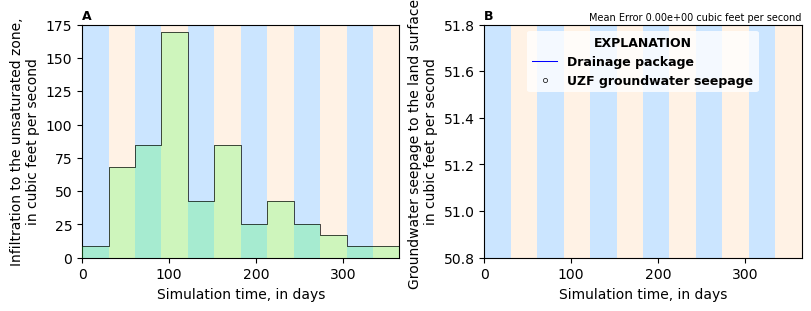

In [7]:
time = drn["totim"] / 86400.0   ; q0 = drn["SURFRATE"]  ; q1 = uzf["SURFRATE"]  ; mean_error = np.mean(q0 - q1)
fig, axes = plt.subplots(ncols=2,nrows=1,sharex=True,figsize=(8, 3),constrained_layout=True,)
ax = axes[0]
ax.set_xlim(0, 365) ; ax.set_ylim(0, 175) ; xp, yp = [0.0], [uzf["NETINFIL"][0]]
for idx in range(time.shape[0]):
    if idx == 0:  x0, x1 = 0.0, time[idx]
    else:         x0, x1 =      time[idx - 1], time[idx]
    y2 = uzf["NETINFIL"][idx]  ; xp.append(x0) ; xp.append(x1) ; yp.append(y2) ; yp.append(y2)
    ax.fill_between([x0, x1],0,y2=y2,lw=0,color="#33FF3D3D",step="post",ec="none",zorder=100,)

ax.plot(xp, yp, lw=0.5, color="black", zorder=101) ; 

plot_stress_periods(ax) ; styles.heading(ax, idx=0)
ax.set_xlabel("Simulation time, in days") ; ax.set_ylabel("Infiltration to the unsaturated zone,\nin cubic feet per second")
ax = axes[-1]
ax.set_xlim(0, 365) ; ax.set_ylim(50.8, 51.8) ; 
ax.plot(time, -drn["SURFRATE"],lw=0.75,ls="-",color="blue",label="Drainage package",)
ax.plot(time, -uzf["SURFRATE"],marker="o",ms=3,mfc="none",mec="black",markeredgewidth=0.5,lw=0.0,ls="-",color="red",label="UZF groundwater seepage",)

plot_stress_periods(ax)
styles.graph_legend(ax, loc="upper center", ncol=1, frameon=True, edgecolor="none") ; styles.heading(ax, idx=1)
styles.add_text(ax,f"Mean Error {mean_error:.2e} cubic feet per second",bold=False,italic=False,x=1.0,y=1.01,va="bottom",ha="right",fontsize=7,)
ax.set_xlabel("Simulation time, in days") ; ax.set_ylabel("Groundwater seepage to the land surface,\nin cubic feet per second")
plt.show()

In [8]:
caption = f"Infiltration and pumping rates for example {sim_name}."
headings = ("Stress period","Infiltration rate","Pumping rate",)
fpth = workspace / f"{sim_name}-02.tex"
dtype = [("nper", "U30"),("infilt", "U30"),("rate", "U30"),]
arr = np.zeros(nper, dtype=dtype)
for n in range(nper):
    arr["nper"][n] = int_format(n + 1) ; arr["infilt"][n] = exp_format(infiltration[n]) ; arr["rate"][n] = float_format(well_rates[n])
col_widths = (0.1, 0.30, 0.30) ; build_table(caption, fpth, arr, headings=headings, col_widths=col_widths)

<font color='blue'> **Unfinished** </font> 